## 09: Вспомогательные функции — загрузка, визуализация зависимости и Спирмен

Файл содержит:
- загрузку данных из БД;
- функцию визуализации зависимости признака от целевой `corrosion_rate`;
- функцию расчёта Спирмена для списка признаков.


In [ ]:
# Импорты и загрузка данных
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if '../src' not in sys.path:
    sys.path.append('../src')
from database import load_corrosion_data_new as load_data
from analysis import AdvancedCorrosionAnalyzer
from bayesian_analysis import BayesianCorrosionAnalyzer


In [6]:
# Настройки
sns.set(style='whitegrid')
TARGET = 'worst_corrosion_rate_mm_per_year'

# Загрузка
DF = load_data()
assert TARGET in DF.columns, 'В данных отсутствует corrosion_rate_mm_per_year'

print(f"Данные: {len(DF):,} строк, {len(DF.columns)} колонок")
print('Колонки:')
print(sorted(DF.columns.tolist()))

Данные: 143,058 строк, 45 колонок
Колонки:
['ammonia_content', 'avg_corrosion_rate_mm_per_year', 'chloride_aggressiveness', 'chlorine_content', 'co2_content', 'component_type_id', 'component_type_name', 'contour', 'corrosion_aggressiveness_index', 'corrosion_inhibitor_content', 'corrosion_protection_index', 'cross_sectional_area', 'diameter_to_thickness_ratio', 'equipment', 'equipment_age_years', 'h2s_aggressiveness_index', 'h2s_content', 'h2s_water_ratio', 'hydrochloric_acid_content', 'inner_diameter', 'installation', 'material_code', 'material_resistance_score', 'material_type', 'measurement_date', 'measurement_points_in_section', 'min_corrosion_rate_mm_per_year', 'nominal_thickness_mmc', 'operating_pressure', 'operating_temperature', 'outer_diameter', 'oxygen_content', 'pitting_corrosion_index', 'section_number', 'stress_corrosion_index', 'tmin_mmc', 'total_acidity_index', 'total_acids', 'total_chlorine_compounds', 'total_sulfur_compounds', 'underdeposit_corrosion_index', 'wall_thic

In [7]:
# Фильтрация по конкретной установке
INSTALLATION_FILTER = 'KK-2'
DF = DF[DF['installation'] == INSTALLATION_FILTER]

print(f"После фильтрации по '{INSTALLATION_FILTER}': {len(DF):,} строк")

После фильтрации по 'KK-2': 11,464 строк


✅ Добавлены инженерные индексы: 13 колонок
   Колонки: ['h2s_aqueous_exposure', 'co2_aqueous_temp_index', 'acid_load_aqueous', 'chloride_aqueous', 'oxygen_aqueous', 'mixed_acid_gas_index', 'aggressiveness_per_resistance', 'protection_gap', 'pitting_chloride_index', 'hoop_stress_proxy', 'thinning_ratio', 'annualized_thinning', 'material_adjusted_stress']


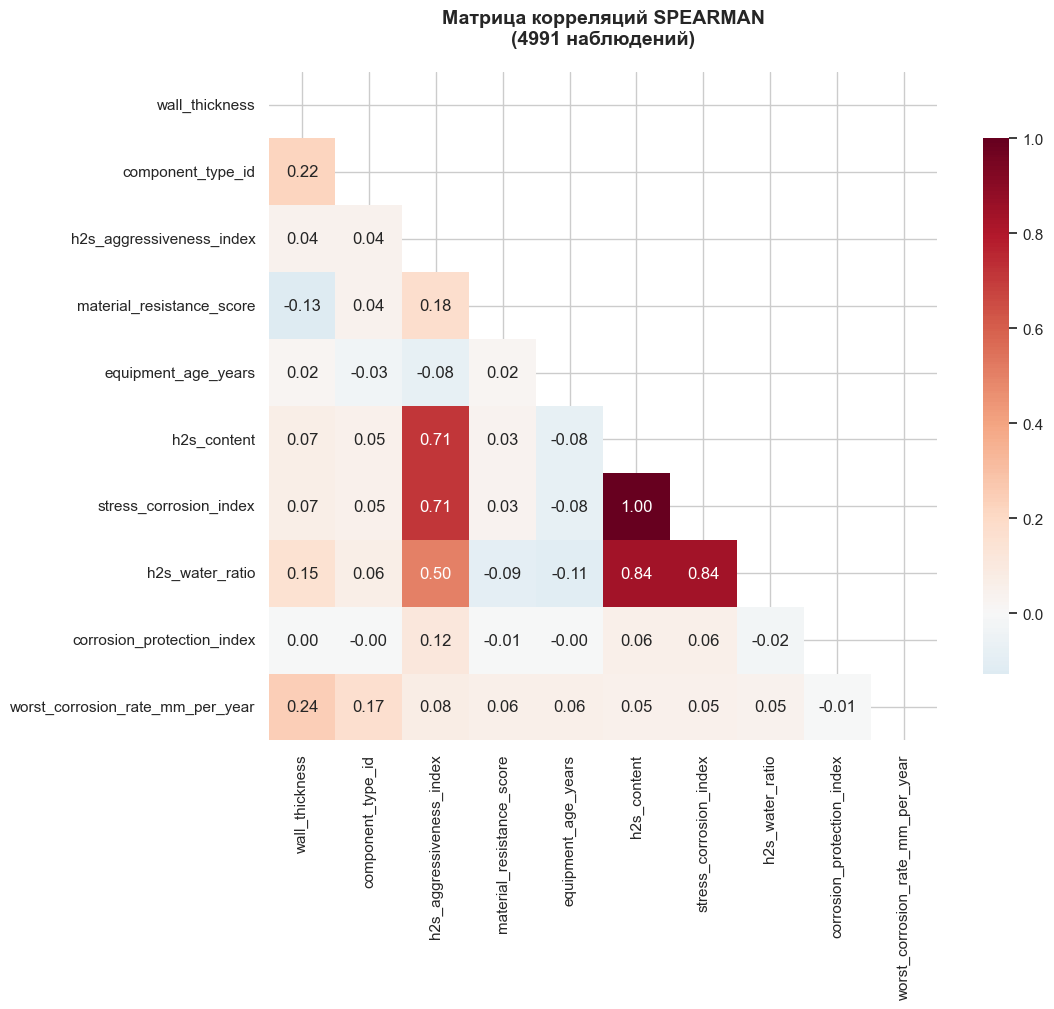

ТОП-9 ПРИЗНАКОВ ПО КОРРЕЛЯЦИИ SPEARMAN

📈 СТАТИСТИЧЕСКИ ЗНАЧИМЫЕ (p < 0.05):
  wall_thickness                 | r =   0.244 *** 🡅
  component_type_id              | r =   0.167 *** 🡅
  h2s_aggressiveness_index       | r =   0.077 *** 🡅
  material_resistance_score      | r =   0.061 *** 🡅
  equipment_age_years            | r =   0.060 *** 🡅
  h2s_content                    | r =   0.054 *** 🡅
  stress_corrosion_index         | r =   0.054 *** 🡅
  h2s_water_ratio                | r =   0.047 *** 🡅

📊 Статистика:
   Всего значимых корреляций: 8
   Максимальная корреляция: 0.244
   Минимальная корреляция: 0.007


In [8]:
# 1. Инициализация с любыми данными
analyzer = AdvancedCorrosionAnalyzer(DF)
# Обогощаем данные
added_cols = analyzer.add_engineered_indices()

# 2. Установка целевой переменной
analyzer.set_target('worst_corrosion_rate_mm_per_year')

# 3. Анализ корреляций для конкретных колонок
features_to_analyze = ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id','corrosion_protection_index','stress_corrosion_index']

correlations = analyzer.analyze_correlations(
    feature_columns=features_to_analyze,
    method='spearman',
    top_k=15,
    plot_matrix=True
)


🔬 Тестируем набор: 1
   Признаки: ['operating_temperature', 'operating_pressure', 'material_resistance_score']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² = -0.0007 | MAE =  0.0621 | RMSE =  0.1071
   random_forest   | R² =  0.1391 | MAE =  0.0575 | RMSE =  0.0994

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.1391)

🔬 Тестируем набор: 2
   Признаки: ['cross_sectional_area', 'component_type_id', 'nominal_thickness_mmc', 'h2s_content', 'operating_temperature', 'operating_pressure', 'water_content']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0975 | MAE =  0.0658 | RMSE =  0.0879
   random_forest   | R² =  0.2346 | MAE =  0.0549 | RMSE =  0.0809

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.2346)

🔬 Тестируем набор: 3
   Признаки: ['h2s_content', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0755 | MAE =  0.0657 | RMSE =  0.0889
   random_forest   | R² =  0.2975 | MAE =  0.0553 

<Figure size 1200x600 with 0 Axes>

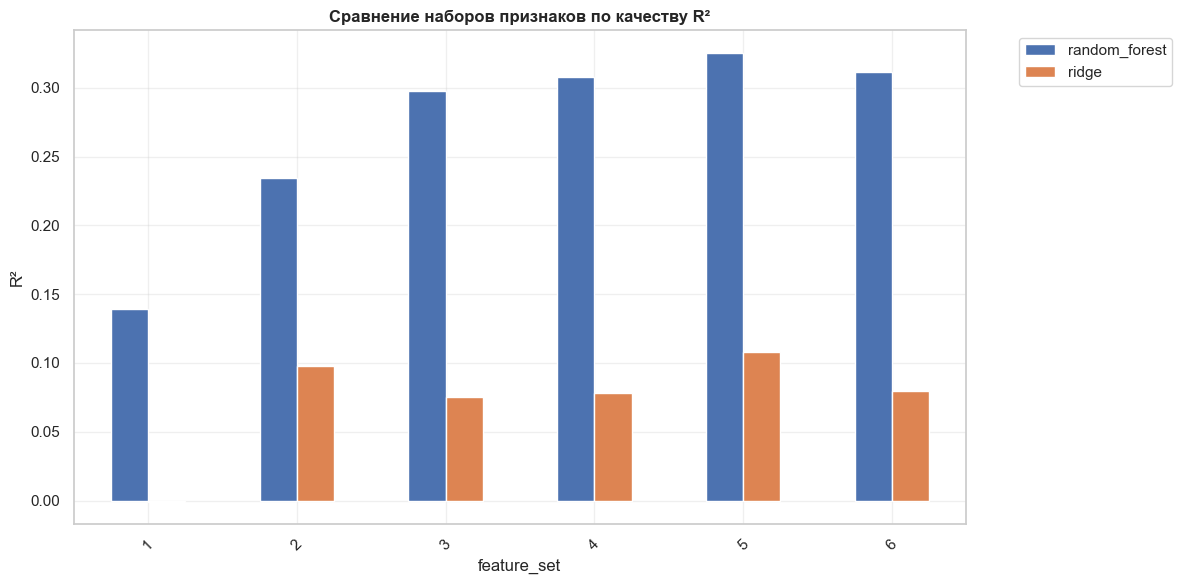

In [9]:
# 5. Сравнение разных наборов признаков
feature_sets = {
    '1': ['operating_temperature', 'operating_pressure', 'material_resistance_score'],
    '2': ['cross_sectional_area','component_type_id','nominal_thickness_mmc','h2s_content','operating_temperature','operating_pressure','water_content'],
    '3': ['h2s_content', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years'],
    '4': ['h2s_content', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id'],
    '5': ['h2s_aggressiveness_index', 'h2s_content', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id'],
    '6': ['h2s_content', 'h2s_water_ratio', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id'],
}

comparison = analyzer.compare_feature_sets(feature_sets)


🔬 Тестируем набор: 5
   Признаки: ['h2s_aggressiveness_index', 'h2s_content', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type_id']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.1076 | MAE =  0.0655 | RMSE =  0.0874
   random_forest   | R² =  0.3254 | MAE =  0.0531 | RMSE =  0.0760

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.3254)

🔬 Тестируем набор: 6
   Признаки: ['h2s_content', 'h2s_water_ratio', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type_id']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0797 | MAE =  0.0657 | RMSE =  0.0887
   random_forest   | R² =  0.3111 | MAE =  0.0534 | RMSE =  0.0768

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.3111)

🔬 Тестируем набор: 7
   Признаки: ['h2s_content', 'h2s_water_ratio', 'h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type

<Figure size 1200x600 with 0 Axes>

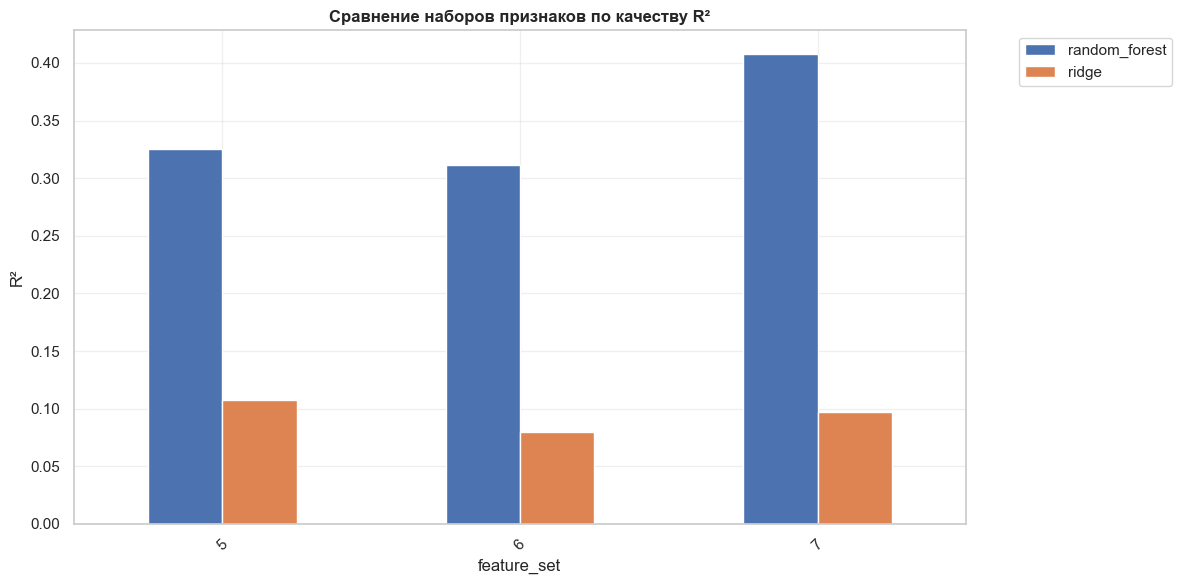

In [10]:
# 6. Сравнение разных наборов признаков
feature_sets = {
    '5': ['h2s_aggressiveness_index', 'h2s_content', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id'],
    '6': ['h2s_content', 'h2s_water_ratio', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id'],
    '7': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id'],

}

comparison = analyzer.compare_feature_sets(feature_sets)


🔬 Тестируем набор: 7
   Признаки: ['h2s_content', 'h2s_water_ratio', 'h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type_id']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0973 | MAE =  0.0694 | RMSE =  0.0968
   random_forest   | R² =  0.4079 | MAE =  0.0515 | RMSE =  0.0784

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.4079)

🔬 Тестируем набор: 8
   Признаки: ['h2s_content', 'h2s_water_ratio', 'h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type_id', 'stress_corrosion_index']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0973 | MAE =  0.0694 | RMSE =  0.0968
   random_forest   | R² =  0.4109 | MAE =  0.0514 | RMSE =  0.0782

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.4109)

🔬 Тестируем набор: 9
   Признаки: ['h2s_content', 'h2s_water_ratio', 'h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type_id', 'corr

<Figure size 1200x600 with 0 Axes>

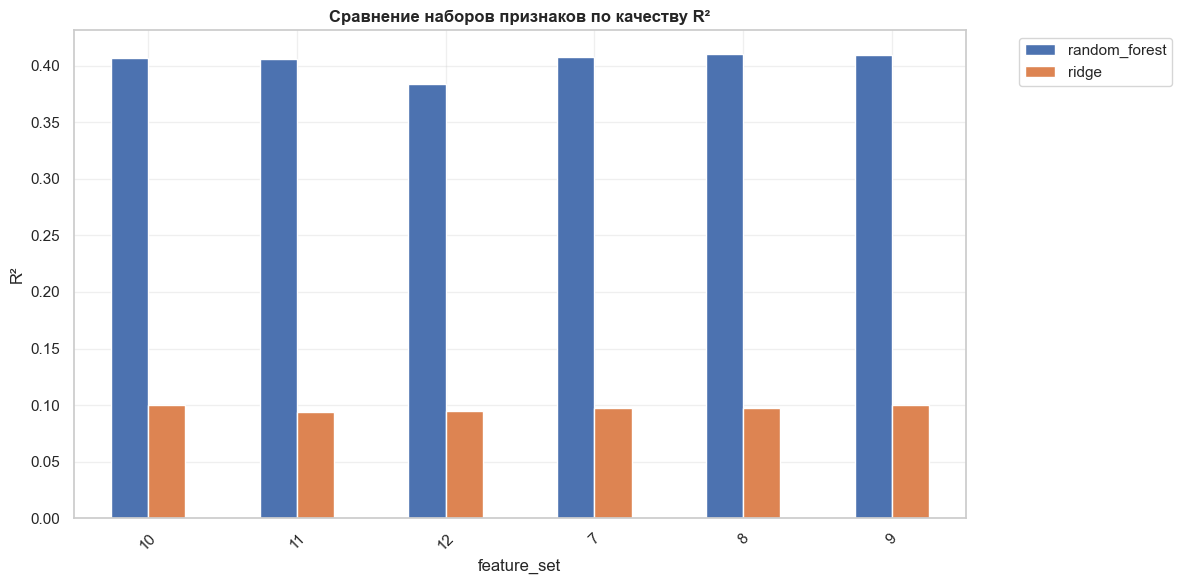

In [20]:
# 6. Сравнение разных наборов признаков
feature_sets = {
    '7': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id'],
    '8': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id','stress_corrosion_index'],
    '9': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id','corrosion_protection_index'],
    '10': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id','corrosion_protection_index','stress_corrosion_index'], 
    '11': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id','corrosion_protection_index','cross_sectional_area'], 
    '12': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id','stress_corrosion_index'],

    
}


comparison = analyzer.compare_feature_sets(feature_sets)


🔬 Тестируем набор: baseline
   Признаки: ['h2s_content', 'h2s_water_ratio', 'h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type_id', 'stress_corrosion_index']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0973 | MAE =  0.0694 | RMSE =  0.0968
   random_forest   | R² =  0.4109 | MAE =  0.0514 | RMSE =  0.0782

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.4109)

📋 Сводная таблица по наборам признаков (Random Forest):
                  R2 Random Forest  MAE Random Forest
Набор параметров                                     
baseline                    0.4109             0.0514


<Figure size 1200x600 with 0 Axes>

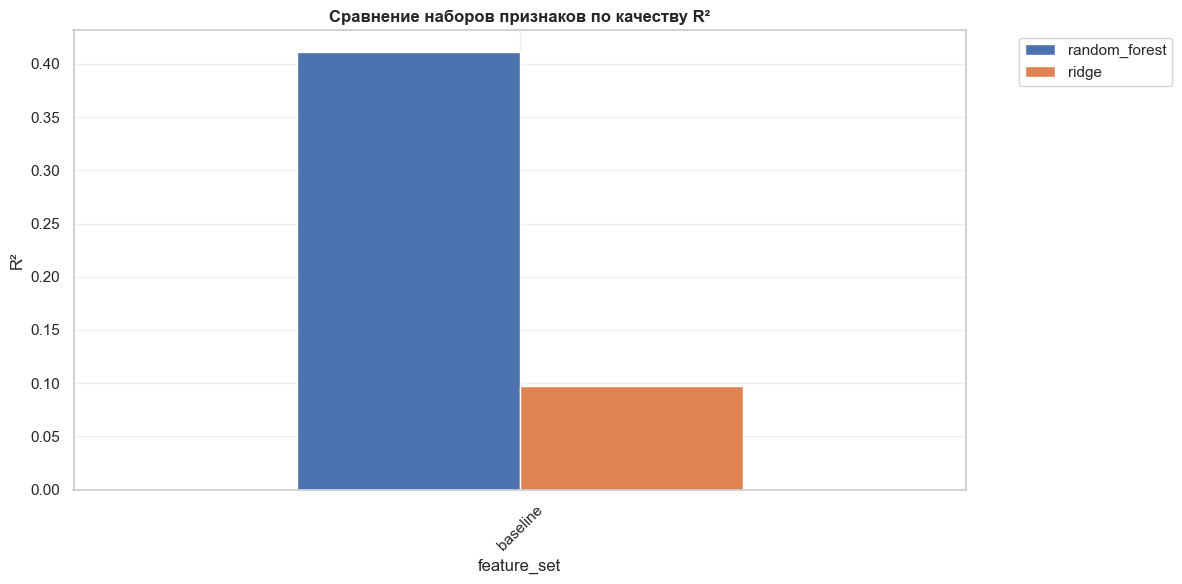

In [25]:
# 6. Сравнение разных наборов признаков
feature_sets = {
    'baseline': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id','stress_corrosion_index'],

    
}


comparison = analyzer.compare_feature_sets(feature_sets)